In [1]:
#%%
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from seg_dataset import SegmentationDataset, RandomFlipRotate
import segmentation_models_pytorch as smp 
import seaborn as sns
import matplotlib.pyplot as plt
from segformer_pytorch import Segformer
import torch.nn.functional as F
import os 
import glob
from torchmetrics.classification.jaccard import MulticlassJaccardIndex as jaccard

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from captum.attr import LayerGradCam, LayerAttribution, visualization as viz
from captum.attr import IntegratedGradients, Occlusion

import os
from skimage import exposure
import time

In [3]:
!wget https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M/resolve/main/Prithvi_100M.pt?download=true -O Prithvi_100M.pt
!wget https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M/resolve/main/Prithvi_100M_config.yaml?download=true -O Prithvi_100M_config.yaml

--2024-11-20 11:37:26--  https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M/resolve/main/Prithvi_100M.pt?download=true
Resolving huggingface.co (huggingface.co)... 18.238.109.52, 18.238.109.102, 18.238.109.121, ...
Connecting to huggingface.co (huggingface.co)|18.238.109.52|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/df/20/df206d490921107b9de9bc65b4652a8697ded18367c8cd5776e07eee4acc573a/69f8ac286f649d1bbed520f5c8560a60eba91d688f74e1a0f9aa8203b6fd62ab?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27Prithvi_100M.pt%3B+filename%3D%22Prithvi_100M.pt%22%3B&Expires=1732387046&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMjM4NzA0Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9kZi8yMC9kZjIwNmQ0OTA5MjExMDdiOWRlOWJjNjViNDY1MmE4Njk3ZGVkMTgzNjdjOGNkNTc3NmUwN2VlZTRhY2M1NzNhLzY5ZjhhYzI4NmY2NDlkMWJiZWQ1MjBmNWM4NTYwYTYwZWJhOTFkNjg4Zjc0ZTFhMGY5YWE4MjAzYjZmZDYyYW

In [1]:
! pip list

Package                       Version      Editable project location
----------------------------- ------------ ------------------------------------
affine                        2.4.0
anyio                         4.0.0
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.3.0
asttokens                     2.4.0
async-lru                     2.0.4
attrs                         23.1.0
Babel                         2.12.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.5
beautifulsoup4                4.12.2
bleach                        6.1.0
bokeh                         3.2.2
boltons                       23.0.0
branca                        0.6.0
brotlipy                      0.7.0
cached-property               1.5.2
captum                        0.7.0
certifi                       2024.6.2
cffi                          1.15.1
charset-normalizer            2.0.4
click                         8.1.7
click-plugins

In [4]:
! wget https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M/resolve/main/Prithvi_100M.pt

--2024-11-20 15:40:53--  https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M/resolve/main/Prithvi_100M.pt
Resolving huggingface.co (huggingface.co)... 18.238.109.92, 18.238.109.52, 18.238.109.121, ...
Connecting to huggingface.co (huggingface.co)|18.238.109.92|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/df/20/df206d490921107b9de9bc65b4652a8697ded18367c8cd5776e07eee4acc573a/69f8ac286f649d1bbed520f5c8560a60eba91d688f74e1a0f9aa8203b6fd62ab?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27Prithvi_100M.pt%3B+filename%3D%22Prithvi_100M.pt%22%3B&Expires=1732401653&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMjQwMTY1M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9kZi8yMC9kZjIwNmQ0OTA5MjExMDdiOWRlOWJjNjViNDY1MmE4Njk3ZGVkMTgzNjdjOGNkNTc3NmUwN2VlZTRhY2M1NzNhLzY5ZjhhYzI4NmY2NDlkMWJiZWQ1MjBmNWM4NTYwYTYwZWJhOTFkNjg4Zjc0ZTFhMGY5YWE4MjAzYjZmZDYyYWI%7EcmVzcG9uc2UtY29

In [9]:
cfg_path = 'Prithvi_100M_config.yaml'
ckpt_path = "Prithvi_100M.pt"

In [6]:
! git clone https://github.com/isaaccorley/prithvi-pytorch.gitb

Cloning into 'prithvi-pytorch'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 46 (delta 14), reused 30 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 1.38 MiB | 5.67 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [15]:
!pip install -e .

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/sebrah13/Desktop/RSclass_LCLUC
  Preparing metadata (setup.py) ... done
  Running setup.py develop for prithvi-pytorch


In [ ]:
!pip install -r prithvi-pytorch/requirements.txt

In [ ]:
import sys
folder_path= "prithvi-pytorch/"
if folder_path not in sys.path:
    sys.path.append(folder_path)

In [10]:
from prithvi_pytorch import PrithviViT
model = PrithviViT(
    ckpt_path=ckpt_path,  # path to pretrained checkpoint Prithvi_100M.pt
    cfg_path=cfg_path,  # path to pretrained config Prithvi_100M_config.yaml
    num_classes=12,  # num classifier classes
    in_chans=8,  # right now only supports the pretrained 6 channels
    img_size=64,  # supports other image sizes than 224
    freeze_encoder=True  # freeze the pretrained prithvi if you just want to linear probe
)

/home/sebrah13/Desktop/RSclass_LCLUC/prithvi-pytorch/prithvi_pytorch/model.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_locati

In [11]:
X = torch.randn(1, 8, 64, 64)
out = model(X)
print(out.shape)

torch.Size([1, 12])


In [28]:
from prithvi_pytorch import PrithviEncoderDecoder

model = PrithviEncoderDecoder(
    ckpt_path=ckpt_path,  # path to pretrained checkpoint Prithvi_100M.pt
    cfg_path=cfg_path,  # path to pretrained config Prithvi_100M_config.yaml
    num_classes=9,  # num classifier classes
    in_chans=8,  # right now only supports the pretrained 6 channels
    img_size=64,  # supports other image sizes than 224
    freeze_encoder=True  # freeze the pretrained prithvi
)

In [13]:
X = torch.randn(1, 8, 64, 64)
out = model(X)
print(out.shape)

torch.Size([1, 9, 64, 64])


In [33]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# %%
EPOCHS = 50
BS = 2

cuda


In [25]:
# #%% Instantiate Dataset and Dataloader
train_ds = SegmentationDataset(data_path='/scratch/sebrah13/RS_class/yearlyImage/Train2')
# sampler = torch.utils.data.WeightedRandomSampler(train_ds.weights, len(train_ds.weights))
train_dataloader = DataLoader(train_ds, batch_size=BS, pin_memory=True)
val_ds = SegmentationDataset(data_path='/scratch/sebrah13/RS_class/yearlyImage/Val2')
# sampler1 = torch.utils.data.WeightedRandomSampler(val_ds.weights, len(val_ds.weights))
val_dataloader = DataLoader(val_ds, batch_size=BS, pin_memory=True)

In [26]:
for DD in val_dataloader:
    print(DD['image'].shape, DD['mask'].shape)
    
    break

torch.Size([2, 8, 64, 64]) torch.Size([2, 64, 64])


In [32]:
model.to(DEVICE)
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])



wights = glob.glob("Prithvi*.pth")
if wights:
    model.load_state_dict(torch.load(f'Prithvi_epochs_{EPOCHS}_crossentropy_state_dict.pth'))
    print("Pretrained weights loaded")
else:
    print("No pretrained weights found, intializing random weights...")    
    %%
criterion = nn.CrossEntropyLoss().to(DEVICE)



IoU = jaccard( num_classes= 9, average='none').to(DEVICE)

train_losses, val_losses = [],[]

/tmp/ipykernel_1498819/4283080810.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'Prithvi_epochs_{EPOCHS}_crossentropy_state_dict.pth

Pretrained weights loaded


In [34]:
Prev_loss = 10000
min_loss = 10000
for e in range(EPOCHS):
    model.train()
    running_train_loss, running_val_loss = 0, 0
    metrics = {'iou_scores': [], 'f1_scores': [], 'f2_scores': [], 'accuracies': [], 'recalls': [], 'ious': [], 'losses': []}
    for i, data in enumerate(train_dataloader):
        #training phase
        image_i, mask_i = data['image'], data['mask']
        image = image_i.to(DEVICE)
        mask = mask_i.to(DEVICE)
        
        # reset gradients
        optimizer.zero_grad() 
        #forward
        output = model(image.float())
        # Upsample the output to match the target label size
        # output_upsampled = output
        output_upsampled =F.interpolate(output, size=mask.shape[1:], mode = 'bilinear',   align_corners=False)
        # calc losses
        train_loss = criterion(output_upsampled .float(), mask.long())

        # back propagation
        train_loss.backward()
        optimizer.step() #update weight          
        running_train_loss += train_loss.item()
        
        # adding metrics
        IoU_metric = IoU(output_upsampled .float(), mask.long())
        _, pred = torch.max(output_upsampled, 1)
        tp, fp, fn, tn = smp.metrics.get_stats(pred, mask.long(), mode='multiclass', num_classes=9)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        #storing the metrics in a dictionary
        metrics['ious'].append(IoU_metric)
        metrics['iou_scores'].append(iou_score)
        metrics['f1_scores'].append(f1_score)
        metrics['f2_scores'].append(f2_score)
        metrics['accuracies'].append(accuracy)
        metrics['recalls'].append(recall)
        metrics['losses'].append(train_loss.item())
        
    train_losses.append(running_train_loss) 
    
    # Compute mean of each metric
    mean_metrics =  {
    metric: np.mean([v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in values])
    for metric, values in metrics.items()
}
    print(f"Epoch: {e}, Training Mean Loss: {mean_metrics['losses']}, Mean IoU: {mean_metrics['ious']}, "
        f"Mean IoU Score: {mean_metrics['iou_scores']}, Mean F1 Score: {mean_metrics['f1_scores']}, ")
        # f"Mean F2 Score: {mean_metrics['f2_scores']}, Mean Accuracy: {mean_metrics['accuracies']}, "
        # f"Mean Recall: {mean_metrics['recalls']}")
    
    # validation
    model.eval()
    val_metrics = {'iou_scores': [], 'f1_scores': [], 'f2_scores': [], 'accuracies': [], 'recalls': [], 'ious': []}
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            image_i, mask_i = data['image'], data['mask']
            image = image_i.to(DEVICE)
            mask = mask_i.to(DEVICE)
            #forward
            output = model(image.float())
            # output_upsampled = output
            
            output_upsampled = F.interpolate(output, size=mask.shape[1:],mode = 'bilinear', align_corners=False)
            # calc losses
            val_loss = criterion(output_upsampled.float(), mask.long())
            running_val_loss += val_loss.item()
            
            # Calculate additional metrics
            _, pred = torch.max(output_upsampled, 1)
            IoU_metric = IoU(output_upsampled.float(), mask.long())
            tp, fp, fn, tn = smp.metrics.get_stats(pred, mask.long(), mode='multiclass', num_classes=9)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
            f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
            recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
            # Store metrics in the validation metrics dictionary
            val_metrics['ious'].append(IoU_metric)
            val_metrics['iou_scores'].append(iou_score)
            val_metrics['f1_scores'].append(f1_score)
            val_metrics['f2_scores'].append(f2_score)
            val_metrics['accuracies'].append(accuracy)
            val_metrics['recalls'].append(recall)
            
    val_losses.append(running_val_loss)
    # Compute mean of each metric and loss
    mean_val_metrics = {
    metric: np.mean([v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in values])
    for metric, values in val_metrics.items()
}
    mean_val_loss = np.mean(running_val_loss / len(val_dataloader))
    # Append the average validation loss for this epoch
    # val_losses.append(mean_val_loss)

# Log or print validation metrics and loss
    print(f"Validation Loss: {mean_val_loss}, Mean IoU: {mean_val_metrics['ious']}, "
      f"Mean IoU Score: {mean_val_metrics['iou_scores']}, Mean F1 Score: {mean_val_metrics['f1_scores']}, ")
    #   f"Mean F2 Score: {mean_val_metrics['f2_scores']}, Mean Accuracy: {mean_val_metrics['accuracies']}, "
    #   f"Mean Recall: {mean_val_metrics['recalls']}")
    
    
    
    if np.median(running_val_loss) < min_loss:
        print(f"Loss value improved from {min_loss} to {np.median(running_val_loss)}; Saving model weights...")
        torch.save(model.state_dict(), f'Prithvi_epochs_{EPOCHS}_crossentropy_state_dict.pth')
        Prev_loss = np.median(running_val_loss)
        if min_loss > Prev_loss:
            min_loss = Prev_loss
            
                # Write report to text file
        with open('report.txt', 'a') as file:  # 'a' mode for appending in case this happens multiple times
            file.write(f"Epoch: {e}, Median Validation Loss: {running_train_loss},\n")
            file.write(f"Epoch: {e}, Median Validation Loss: {running_val_loss},\n")
            file.write("Mean Validation Metrics:\n")
            for metric, value in mean_val_metrics.items():
                file.write(f"{metric}: {value}\n")
            file.write("Metrics training Criteria (if any):\n")
            for metric, value in mean_metrics.items():
                file.write(f"{metric}: {value}\n")
           
    print(f"Epoch: {e}: Train Cumulative Loss: {np.median(running_train_loss)}, Val cumulative Loss: {np.median(running_val_loss)} ")


Epoch: 0, Training Mean Loss: 1.930797003507614, Mean IoU: 0.03489799052476883, Mean IoU Score: 0.20976020395755768, Mean F1 Score: 0.3136059641838074, 
Validation Loss: 1.9878508591651916, Mean IoU: 0.03383423015475273, Mean IoU Score: 0.1998787671327591, Mean F1 Score: 0.3045080602169037, 
Loss value improved from 10000 to 198.78508591651917; Saving model weights...
Epoch: 0: Train Cumulative Loss: 193.0797003507614, Val cumulative Loss: 198.78508591651917 
Epoch: 1, Training Mean Loss: 1.9294772398471833, Mean IoU: 0.03489314764738083, Mean IoU Score: 0.2096715122461319, Mean F1 Score: 0.3135437071323395, 
Validation Loss: 1.9834326565265656, Mean IoU: 0.03383423015475273, Mean IoU Score: 0.1998787671327591, Mean F1 Score: 0.3045080602169037, 
Loss value improved from 198.78508591651917 to 198.34326565265656; Saving model weights...
Epoch: 1: Train Cumulative Loss: 192.94772398471832, Val cumulative Loss: 198.34326565265656 
Epoch: 2, Training Mean Loss: 1.9285385966300965, Mean IoU

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


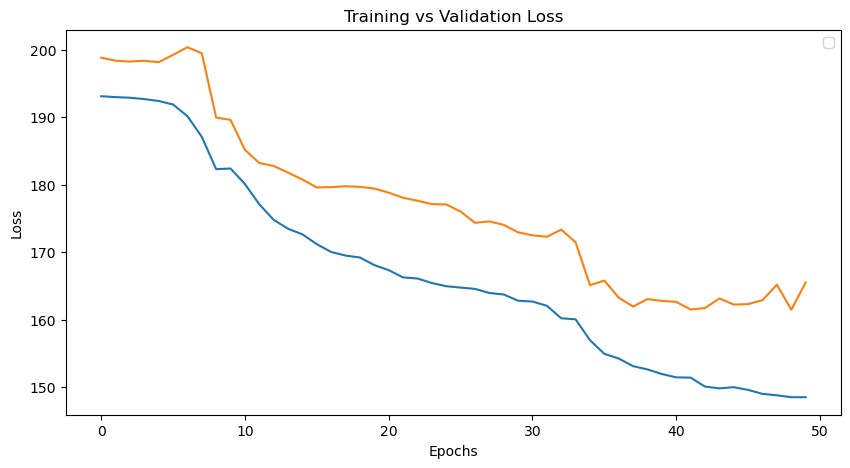

In [35]:
#%% TRAIN LOSS
plt.figure(figsize=(10, 5))  
sns.lineplot(x = range(len(train_losses)), y= train_losses)
sns.lineplot(x = range(len(train_losses)), y= val_losses)

# Adding titles and labels
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()  # Show legend to identify the lines
plt.savefig('trainloss.png')
plt.show()  # Display the plotplt.show()

In [38]:
test_dir = '/scratch/sebrah13/RS_class/yearlyImage/Val2'
test_ds = SegmentationDataset(data_path=test_dir)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=True)

model_path = 'Prithvi_epochs_50_crossentropy_state_dict.pth'


In [39]:
model.eval()
model.to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))

/tmp/ipykernel_1498819/2482370818.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))


<All keys matched successfully>

In [40]:
# %% Helper functions to calculate metrics
def calculate_metrics(tp, fp, fn, tn):
    epsilon = 1e-7
    f1 = 2 * tp / (2 * tp + fp + fn + epsilon)
    f2 = 5 * tp / (5 * tp + 4 * fn + fp + epsilon)
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    recall = tp / (tp + fn + epsilon)
    return f1, f2, accuracy, recall

# %% Model Evaluation
num_classes = 9
tp = np.zeros(num_classes)
fp = np.zeros(num_classes)
fn = np.zeros(num_classes)
tn = np.zeros(num_classes)  # Added true negatives

all_true_labels, all_pred_labels = [],[]

with torch.no_grad():
    for data in test_dataloader:
        inputs, outputs = data['image'], data['mask']
        true = outputs.to(torch.float32).to(DEVICE)
        pred = model(inputs.to(DEVICE).float())
        pred = F.interpolate(pred, size=true.shape[1:], mode = 'bilinear',   align_corners=False)
        _, predicted = torch.max(pred, 1)
        
        all_true_labels.extend(true.cpu().numpy().flatten())
        all_pred_labels.extend(predicted.cpu().numpy().flatten())

        for cls in range(num_classes):
            tp[cls] += torch.sum((predicted == cls) & (true == cls)).item()
            fp[cls] += torch.sum((predicted == cls) & (true != cls)).item()
            fn[cls] += torch.sum((predicted != cls) & (true == cls)).item()
            tn[cls] += torch.sum((predicted != cls) & (true != cls)).item()  # Correctly count true negatives

# Compute IoU for each class
class_iou = tp / (tp + fp + fn + 1e-7)
mean_iou = np.mean(class_iou)

# Compute additional metrics
f1_scores, f2_scores, accuracies, recalls = calculate_metrics(tp, fp, fn, tn)
mean_f1 = np.mean(f1_scores)
mean_f2 = np.mean(f2_scores)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)

print(f"Class-wise IoUs: {class_iou}")
print(f"Mean IoU: {mean_iou}")
print(f"Mean F1 Score: {mean_f1}")
print(f"Mean F2 Score: {mean_f2}")
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Recall: {mean_recall}")


Class-wise IoUs: [0.00000000e+00 0.00000000e+00 3.18715936e-01 0.00000000e+00
 3.99178677e-01 1.20972152e-02 2.16201801e-01 3.68960901e-04
 2.73961042e-01]
Mean IoU: 0.13561373689681705
Mean F1 Score: 0.20713726446673678
Mean F2 Score: 0.24197058300572413
Mean Accuracy: 0.8672059461804497
Mean Recall: 0.2770990835424792


/tmp/ipykernel_1498819/3574719215.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.ax.set_yticklabels([f'{int(i)}%' for i in colorbar.get_ticks()], fontsize=14, fontname='Times New Roman')
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


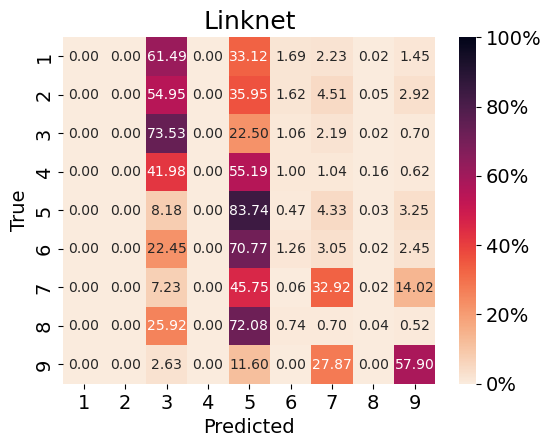

In [41]:
#%% Confusion Matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd


Name = 'Prithvi'

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_pred_labels, labels=list(range(num_classes)))

# Normalize confusion matrix by row (true labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Convert to percentage
conf_matrix_normalized *= 100
# Create a custom colormap
cmap = sns.color_palette("rocket_r", as_cmap=True)
# Plot normalized confusion matrix
plt.figure(figsize=(6, 4.5))
ax = sns.heatmap(pd.DataFrame(conf_matrix_normalized, columns=[f'{i+1}' for i in range(num_classes)], 
                         index=[f'{i+1}' for i in range(num_classes)]), 
            annot=True, fmt='.2f', cmap=cmap, vmin=0, vmax=100)

# Set font properties
plt.xlabel('Predicted', fontsize=14, fontname='Times New Roman')
plt.ylabel('True', fontsize=14, fontname='Times New Roman')
plt.title(f'{Name}'
        #   {config_name[-5:]}'
          , fontsize=18, fontname='Times New Roman')

# Set ticks font properties
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontname='Times New Roman')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, fontname='Times New Roman')

# Adjust color bar font properties
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)
colorbar.ax.set_yticklabels([f'{int(i)}%' for i in colorbar.get_ticks()], fontsize=14, fontname='Times New Roman')

plt.savefig(f'normalized_confusion_matrix{Name}.png')
plt.show()

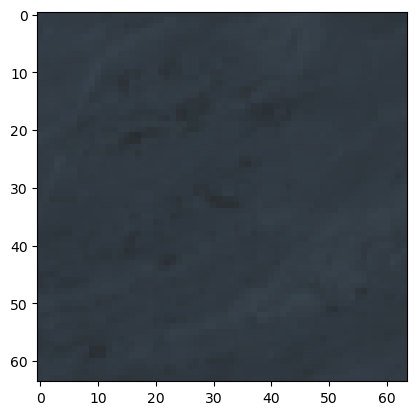

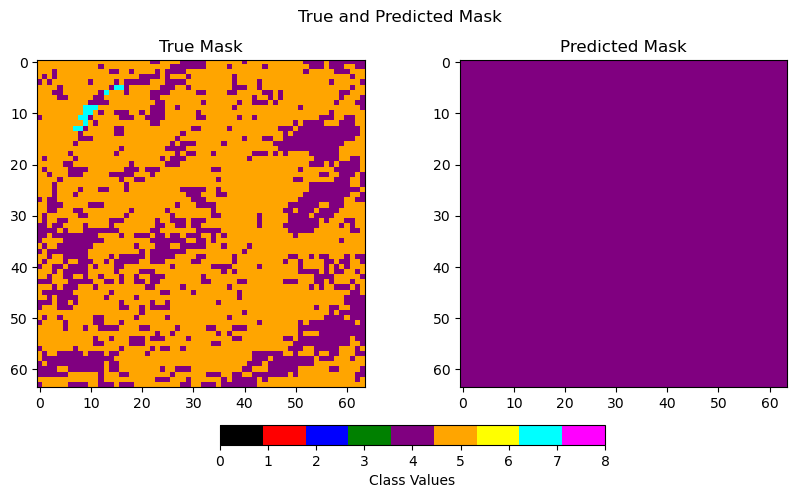

[4]
[4. 5. 7.]


In [42]:
#%% Pick a test image and show it
from matplotlib.colors import ListedColormap
Sample = next(iter(test_dataloader))
image_test, mask = Sample['image'], Sample['mask']
plt.imshow(np.transpose(image_test[0, 0:3, :, :].cpu().numpy(), (1, 2, 0)))

#%% EVALUATE MODEL
# create preds
with torch.no_grad():
    image_test = image_test.float().to(DEVICE)
    output = model(image_test)

#%%
output_cpu = output.cpu().squeeze().numpy()
Output = output_cpu[:,:,:]
output_cpu = Output.transpose((1, 2, 0))
output_cpu = output_cpu.argmax(axis=2)

# %%



# Define a color map with 9 distinct colors for values 0 to 8
colors = ['black', 'red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan', 'magenta']
cmap = ListedColormap(colors)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle('True and Predicted Mask')

true_mask_img = axs[0].imshow(mask[0, :, :], cmap=cmap, vmin=0, vmax=8)
predicted_mask_img = axs[1].imshow(output_cpu, cmap=cmap, vmin=0, vmax=8)

# Add titles
axs[0].set_title("True Mask")
axs[1].set_title("Predicted Mask")

# Add color bar to interpret the values
fig.colorbar(true_mask_img, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1, label='Class Values')

# Save and display the plot
plt.savefig('Predicted_Mask.png')
plt.show()

# %%
print(np.unique(output_cpu))
print(np.unique(mask[0, :, :].numpy()))